<a href="https://colab.research.google.com/github/nguyenquochuy2311/Banking-Big-Data/blob/main/Banking_BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cài đặt các dependency và start Spark

In [8]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql.functions import lit

import numpy as np
import math
import pyspark.sql.functions as F
from pyspark.sql.functions import count, when, isnan, col

from termcolor import colored

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from math import sqrt
from math import pi
from math import exp

In [10]:
spark = SparkSession.builder.master("local").appName("Colab").getOrCreate()

In [11]:
#Đọc file csv và đếm số dòng, cột
df = spark.read.csv(r'Churn_Modelling.csv', 
                        sep=',',
                        header=True,
                        inferSchema=True,
                        nullValue='NA')

df.printSchema()
print('Tong so dong:',df.count())
print('Tong so cot:',len(df.columns))

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)

Tong so dong: 10000
Tong so cot: 14


In [12]:
#Lấy Top 5 dòng đầu tiên
df.toPandas().head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Util - Gán biến cho bộ dữ liệu

In [13]:
def print_table(data, columns):
  df = pd.DataFrame(data, columns=columns)
  return df

# Explore bộ dữ liệu

In [14]:
#Kiểm tra các cột tồn tại giá trị NULL
df.select([count(when(df[c].isNull(),1)).alias(c) for c in df.columns]).toPandas().T

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [15]:
#Kiểm tra các cột tồn tại giá trị N/A
df.select([count(when(isnan(c),1)).alias(c) for c in df.columns]).toPandas().T

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [16]:
#Mô tả bộ dữ liệu (đếm, giá trị trung bình, độ lệch chuẩn, giá trị max, min)
describe_cols =[c for c in df.columns if c not in ('RowNumber', 'CustomerId', 'Surname')] # ignore 1 vài cột không liên quan đến việc xử lý
df.describe(*describe_cols).toPandas().T #show

,0,1,2,3,4
summary,count,mean,stddev,min,max
CreditScore,10000,650.5288,96.65329873613035,350,850
Geography,10000,None,None,France,Spain
Gender,10000,None,None,Female,Male
Age,10000,38.9218,10.487806451704587,18,92
Tenure,10000,5.0128,2.8921743770496837,0,10
Balance,10000,76485.88928799961,62397.40520238599,0.0,250898.09
NumOfProducts,10000,1.5302,0.5816543579989917,1,4
HasCrCard,10000,0.7055,0.45584046447513327,0,1
IsActiveMember,10000,0.5151,0.49979692845891815,0,1


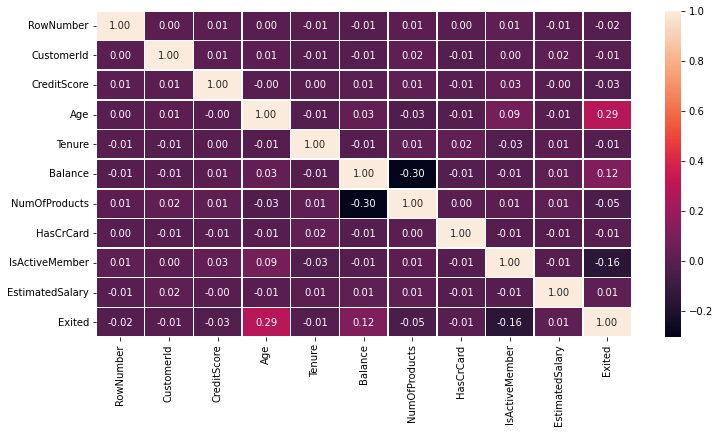

In [17]:
#Bản đồ nhiệt (ma trận) tương quan
fig, ax = plt.subplots(figsize=(12,6)) 
sns.heatmap(df.toPandas().corr(), annot = True, fmt = ".2f", linewidths=0.5, ax=ax) 
plt.show()

RowNumber         -0.016571
CustomerId        -0.006248
CreditScore       -0.027094
Age                0.285323
Tenure            -0.014001
Balance            0.118533
NumOfProducts     -0.047820
HasCrCard         -0.007138
IsActiveMember    -0.156128
EstimatedSalary    0.012097
Exited             1.000000
dtype: float64

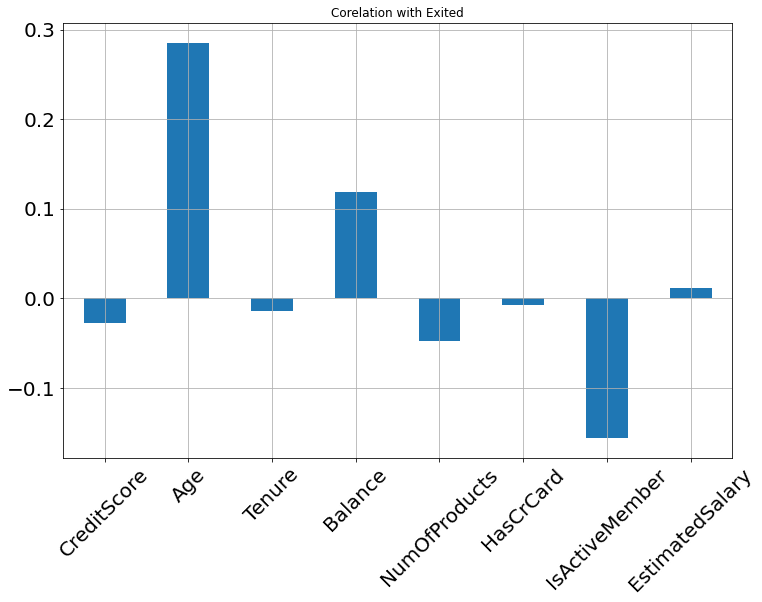

In [18]:
# => Thuộc tính "Exited" quyết định, cần xác định những thuộc tính liên quan đến bài toán (trừ 3 cột RowNumber, CustomerId, Surname)
pd_df = df.toPandas()
pd_df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis = 1).corrwith(pd_df['Exited']).plot.bar(figsize = (12, 8), title = "Corelation with Exited", fontsize = 20, rot = 45, grid = True)
pd_df.corrwith(pd_df['Exited'])
# => Giá trị tương quan của thuộc tính "Exited" với các thuộc tính còn lại

# Trực quan hoá dữ liệu

In [19]:
#
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

In [20]:
#
def draw_chart(col, title, binwidth):
    data_RDD = df.select(col).rdd.flatMap(lambda x: x)
    data = data_RDD.collect()
    print(colored(title, 'green', attrs=['bold']))
    plt.figure(figsize = (12,6))
    sns.histplot(data, binwidth = binwidth)
    plt.show() 

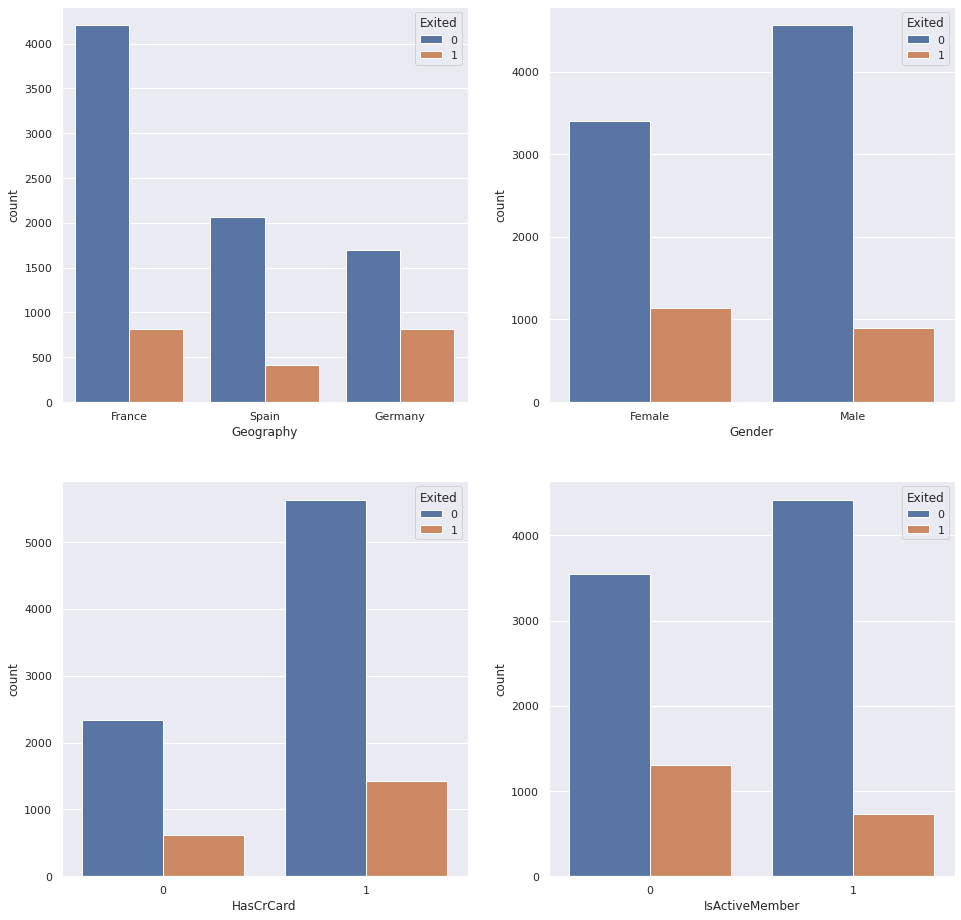

In [21]:
#
fig, axarr = plt.subplots(2, 2, figsize=(16, 16))
sns.countplot(x='Geography', hue = 'Exited',data = df.toPandas(), ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df.toPandas(), ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df.toPandas(), ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df.toPandas(), ax=axarr[1][1])

## Age

Biểu đồ thể hiện phân bố độ tuổi (Age) của các khách hàng trong bộ dữ liệu


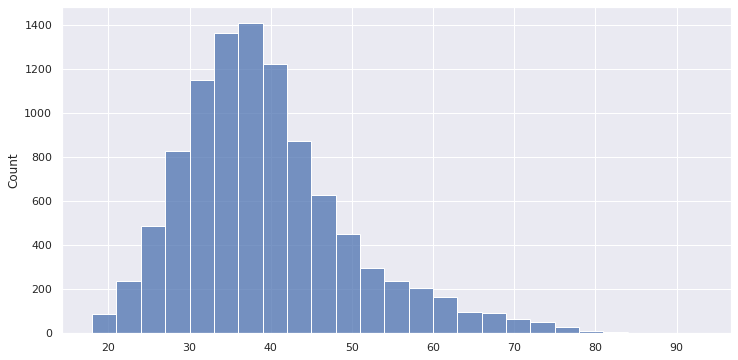

In [22]:
title = "Biểu đồ thể hiện phân bố độ tuổi (Age) của các khách hàng trong bộ dữ liệu"
draw_chart("Age", title, 3)

## CreditScore

Biểu đồ thể hiện phân bố CreditScore của các khách hàng trong bộ dữ liệu


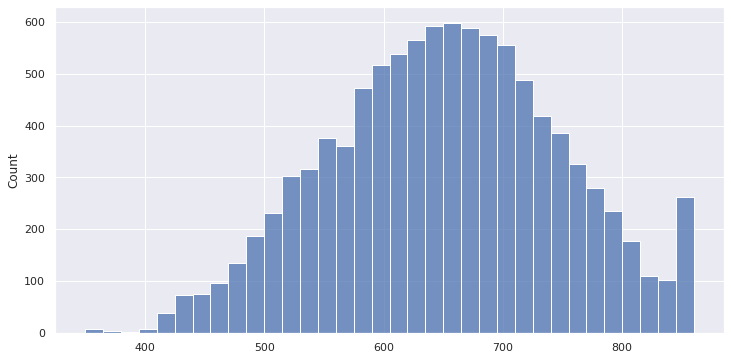

In [23]:
title = "Biểu đồ thể hiện phân bố CreditScore của các khách hàng trong bộ dữ liệu"
draw_chart("CreditScore", title, 15)

## Tenure

Biểu đồ thể hiện phân bố Tenure của các khách hàng trong bộ dữ liệu


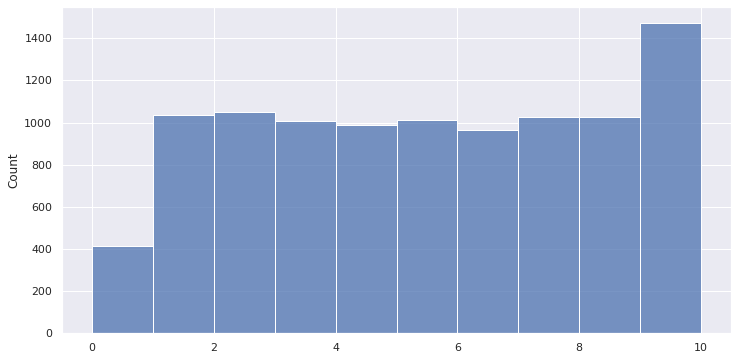

In [24]:
#Tenure: Số năm khách hàng gắn bó
title = "Biểu đồ thể hiện phân bố Tenure của các khách hàng trong bộ dữ liệu"
draw_chart("Tenure", title, 1)

## Balance

Biểu đồ thể hiện phân bố Balance của các khách hàng trong bộ dữ liệu


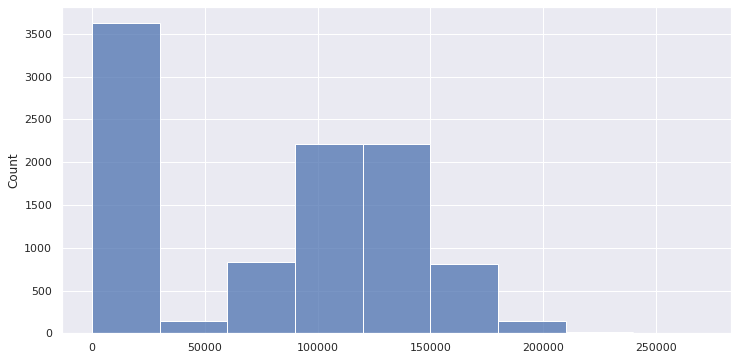

In [26]:
title = "Biểu đồ thể hiện phân bố Balance của các khách hàng trong bộ dữ liệu"
draw_chart("Balance", title, 30000)

# Tiền xử lý dữ liệu

In [27]:
label = "Exited"

In [28]:
#Xử lý các cột dữ liệu được sử dụng
#Gán 0: Female và 1: Male
df = df.replace('Female', '0')
df = df.replace('Male','1')

columns_list = ['Gender']

for item in columns_list:
    df = df.withColumn(item, df[item].cast(IntegerType()))

In [29]:
geography_set = df.select("Geography").distinct().rdd.flatMap(lambda x: x).collect()
geography_expr = [F.when(F.col("Geography") == geography, 1).otherwise(0).alias("Geography_" + geography) for geography in geography_set]

In [30]:
#Lựa chọn các cột sử dụng
df = df.select( "CreditScore",
 "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "EstimatedSalary",
 "IsActiveMember", *geography_expr, "Exited")

In [31]:
#Lấy Top 5 dòng
df.toPandas().head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary,IsActiveMember,Geography_Germany,Geography_France,Geography_Spain,Exited
0,619,42,2,0.00,1,1,101348.88,1,0,1,0,1
1,608,41,1,83807.86,1,0,112542.58,1,0,0,1,0
2,502,42,8,159660.80,3,1,113931.57,0,0,1,0,1
3,699,39,1,0.00,2,0,93826.63,0,0,1,0,0
4,850,43,2,125510.82,1,1,79084.10,1,0,0,1,0


In [32]:
df.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- Geography_Germany: integer (nullable = false)
 |-- Geography_France: integer (nullable = false)
 |-- Geography_Spain: integer (nullable = false)
 |-- Exited: integer (nullable = true)



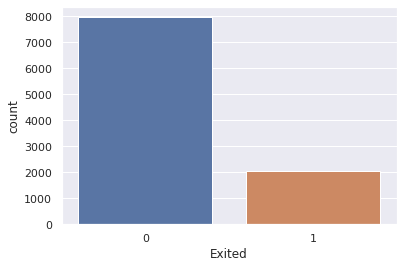

In [33]:
#Thống kê số lượng khách hàng có ở lại sử dụng dịch vụ và không ở lại
import matplotlib.pyplot as plt
sns.countplot(x= label,data = df.toPandas())
plt.show()

In [34]:
#Mô tả bộ dữ liệu (đếm, giá trị trung bình, độ lệch chuẩn, giá trị max, min)
df = df.na.drop()
df.describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+-------------------+------------------+------------------+------------------+-------------------+
|summary|      CreditScore|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|  EstimatedSalary|     IsActiveMember| Geography_Germany|  Geography_France|   Geography_Spain|             Exited|
+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+-------------------+------------------+------------------+------------------+-------------------+
|  count|            10000|             10000|             10000|            10000|             10000|              10000|            10000|              10000|             10000|             10000|             10000|              10000|
|   mean|         650.5288|           38.9218|  

# Xác định Model cho thuật toán

## Native Bayes

In [35]:
class NativeBayes:
    def __init__(self, train, test, label):
        self.train = train
        self.test = test
        self.label = label

    def mean(self, train_y, numbers):
        return (train_y.groupBy().mean(numbers).collect())[0][0]

    def stdev(self, train_y, numbers):
        avg = self.mean(train_y, numbers)
        lendf = len(train_y.select(numbers).collect())
        value = train_y.select(numbers).rdd.flatMap(lambda x: x).collect()
        variance = sum([(x-avg)**2 for x in value]) / float(lendf - 1)
        return sqrt(variance)

    # Trả về các giá trị mean, stdev, count for each columns in train (Dữ liệu đầu vào)
    def summarize_dataset(self, filter_train):
        summaries = [(self.mean(filter_train, column), self.stdev(filter_train, column), filter_train.select(column).count())
                     for column in filter_train.columns]
        del(summaries[-1])
        return summaries

    #Tính toán các giá trị thống kê cho từng cột theo biến phân lớp trên tập dữ liệu train (huấn luyện)
    def summarize_by_class(self, train):
        summaries = dict()
        len_exited = len(train.select([self.label]).rdd.flatMap(
            lambda x: x).distinct().collect())
        for i in range(0, len_exited):
            item = train.select([self.label]).rdd.flatMap(
                lambda x: x).distinct().collect()[i]
            filter_train = train.filter(train[self.label] == item)
            summaries[item] = self.summarize_dataset(filter_train)
        return summaries #Kết quả trả về dưới dạng một danh sách các bộ thống kê theo giá trị lớp tương ứng dưới dạng dictionary

    #Tính xác suất dữ liệu thuộc từng lớp
    def calculate_class_probabilities(self, summaries, row):
        # Tính cho dòng đầu tiên thôi vì các dòng là như nhau
        total_rows = sum([summaries[label][0][2] for label in summaries])
        probabilities = dict()
        for class_value, class_summaries in summaries.items():
            # Tính P(C) : Tổng số lượng hàng được lữu trữ trong hàm thống kê tính từ bộ train và test
            probabilities[class_value] = summaries[class_value][0][2] / \
                float(total_rows)
            
            for i in range(0, len(class_summaries)):
                mean, stdev, _ = class_summaries[i]
                probabilities[class_value] *= self.calculate_probability(
                    row[i], mean, stdev) # P(C) * P(X|C): Xác suất được tính mỗi giá trị đầu vào trong một hàng bằng cách sử dụng calculate_probability
        return probabilities #Quá trình lặp lại cho mỗi lớp dữ liệu.

    #Tính toán mật độ xác suất Gaussian
    #Ta có công thức hàm phân phối xác suất Gaussian với:	σ - độ lệch chuẩn(stdev) và	µ - giá trị trung bình
    def calculate_probability(self, x, mean, stdev):
        exponent = exp(-((x-mean)**2 / (2 * stdev**2)))
        return (1 / (sqrt(2 * pi) * stdev)) * exponent

    #Hàm dự đoán: Tính xác suất của một hàng mới và chọn lớp có xác suất cao nhất
    def predict(self, summaries, row):
        probabilities = self.calculate_class_probabilities(summaries, row)
        best_label, best_prob = None, -1
        for class_value, probability in probabilities.items():
            if best_label is None or probability > best_prob:
                best_prob = probability
                best_label = class_value
        return best_label

#   return y label
    def fit(self):
        summarize = self.summarize_by_class(self.train)
        predictions = list()
        for row in self.test.collect():
            output = self.predict(summarize, row)
            predictions.append(output)
        return(predictions)

## Logistic Regression

In [36]:
#Xây dựng hàm Sigmoid (hàm đầu vào là giá trị bất kỳ và trả về giá trị nằm trong khoảng 0->1)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [37]:
#Hàm dự đoán (hàm nhận đầu vào tập dữ liệu và các tham số theta để đưa ra xác suất phân lớp)
#Giá trị trả về là 1 khi > 0.5 và ngược lại
def predict(test, theta):
    rdd_kq = test.rdd.map(lambda x:(sigmoid(sum(float(x[i])*float(theta[i]) for i in range(len(x)-1)))))
    return rdd_kq.map(lambda x: (1 if x >=0.5 else 0)).collect()

In [38]:
#Xây dựng hàm Gradient Descent (hàm nhận đầu vào là tập dữ liệu, giá trị tham số, alpha và số vòng lặp nhằm tìm được tham số của mô hình hồi qui)
def gradient_descent(X, theta, alpha, num_inters):
    m = X.count()
    for i in range(num_inters):
        delta = X.map(
            lambda p: np.array(p['x']) * (sigmoid(np.dot(p['x'], theta))-p['y'])).reduce(lambda x, y: x+y)
        
        theta -= delta*alpha/m
    return theta

# Đánh giá mô hình

In [39]:
#Xây dựng hàm evaluate_algorithm (đầu vào là 2 tham số cần dự đoán và nhãn thực tế của lớp)
#Kết quả trả về độ chính xác và biểu đồ Plot
def evaluate_algorithm(predicted, label):
    # predicted = algorithm()
    actual = test.select(label).rdd.flatMap(lambda x: x).collect()

    y_true = np.array(actual).astype(int)
    y_pred = np.array(predicted).astype(int)

    accuracy = acc(y_true, y_pred)
    cm = generate_confusion_matrix(y_true, y_pred)

    # plot confussion_matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.0f')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Accuracy Score: {0}'.format(round(accuracy,2))
    plt.title(title, size=15)

In [40]:
#Tính độ chính xác (acc) là trung bình cộng k giá trị chính xác
#Trong bài toán: tính tỉ lệ giữa số điểm được dự đoán và tổng số điểm trong tạp dự liệu kiểm thử
def acc(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return float(correct)/y_true.shape[0]

In [46]:
#Tính confussion_matix (ma trận nhầm lẫn) - xác định lớp nào được phân loại đúng nhiều nhất
#Thể hiện có bao nhiêu điểm dữ liệu thực sự phụ thuộc vào một class và dự đoán rơi vào một class
#Tổng các phần tử trong ma trận -> Số điểm trong tập kiểm thử
#Các phần tử trên đường chéo -> Số điểm được phân loại đúng của mỗi lớp dữ liệu
# => accurancy = tổng phần tử trên đường chéo / tổng phần tử toàn ma trận
def generate_confusion_matrix(y_true, y_pred):
    N = np.unique(y_true).shape[0] # number of classes 
    cm = np.zeros((N, N))

    for n in range(y_true.shape[0]):
        cm[y_true[n], y_pred[n]] += 1
    print(cm.astype(int))
    return cm.astype(int)

# Kiểm thử mô hình

In [42]:
#Phương pháp Hold-out
#Chia thành 2 tập độc lập train/test: 80% / 20%
train, test = df.randomSplit([0.8, 0.2])

## Native Bayes

In [43]:
#Khai báo tập train và test thuật toán NativeBayes
native_bayes = NativeBayes(train=train,test=test, label=label)
predicted = native_bayes.fit()

[[1489  106]
 [ 271  150]]


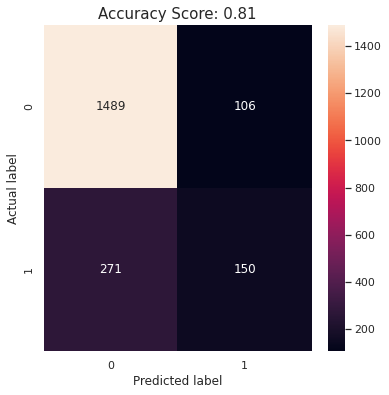

In [44]:
evaluate_algorithm(predicted, label=label)
#Độ chính xác của mô hình là 0.81
#Total	  0	    1	
        0	1489	106	  1595
        1	271	  150	  421
# Bài toán chỉ với 2 class => độ chính xác nhỏ nhất là 1/2 khi tất cả các điểm được dự đoán là thuộc vào một class nào đó

## Logistic Regression

In [47]:
train_lg = train.withColumn('X', lit(1)).withColumn('target', train[label]).drop(label)

In [48]:
train_lg.collect()

[Row(CreditScore=350, Age=39, Tenure=0, Balance=109733.2, NumOfProducts=2, HasCrCard=0, EstimatedSalary=123602.11, IsActiveMember=0, Geography_Germany=1, Geography_France=0, Geography_Spain=0, X=1, target=1),
 Row(CreditScore=350, Age=40, Tenure=0, Balance=111098.85, NumOfProducts=1, HasCrCard=1, EstimatedSalary=172321.21, IsActiveMember=1, Geography_Germany=0, Geography_France=1, Geography_Spain=0, X=1, target=1),
 Row(CreditScore=350, Age=51, Tenure=10, Balance=0.0, NumOfProducts=1, HasCrCard=1, EstimatedSalary=125823.79, IsActiveMember=1, Geography_Germany=0, Geography_France=1, Geography_Spain=0, X=1, target=1),
 Row(CreditScore=350, Age=60, Tenure=3, Balance=0.0, NumOfProducts=1, HasCrCard=0, EstimatedSalary=113796.15, IsActiveMember=0, Geography_Germany=0, Geography_France=1, Geography_Spain=0, X=1, target=1),
 Row(CreditScore=351, Age=57, Tenure=4, Balance=163146.46, NumOfProducts=1, HasCrCard=1, EstimatedSalary=169621.69, IsActiveMember=0, Geography_Germany=1, Geography_France=

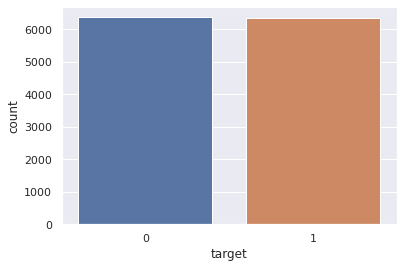

In [49]:
df_class_0 = train_lg.filter(train_lg["target"] == 0)
df_class_1 = train_lg.filter(train_lg["target"] == 1)

df_class_1_over = df_class_1.sample(True, df_class_0.count() / df_class_1.count())
df_train_over = df_class_0.union(df_class_1_over)

sns.countplot(x= "target",data = df_train_over.toPandas())
plt.show()

In [50]:
theta = np.zeros(len(df_train_over.columns)-1)
mapped_train_data = df_train_over.rdd.map(list).map(lambda p: { 'x': p[:len(p)-1], 'y': p[-1]})
theta = gradient_descent(mapped_train_data, theta, 0.1, 100)

In [51]:
predicted = predict(test, theta)

[[1508   87]
 [ 383   38]]


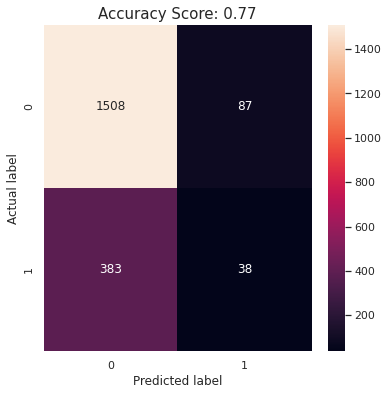

In [52]:
evaluate_algorithm(predicted, label=label)
#Độ chính xác của mô hình là 0.77
#Total	  0	    1	
        0	1508	87	  1595
        1	383	  38	  421
# Bài toán chỉ với 2 class => độ chính xác nhỏ nhất là 1/2 khi tất cả các điểm được dự đoán là thuộc vào một class nào đó